In [1]:
import sys
sys.path.append('/fsx/matzeni/duck')

In [2]:
import torch
from einops import rearrange, repeat
from duck.box_tensors import BoxTensor
from matplotlib import pyplot as plt
import math

In [3]:
# plt.style.use('seaborn')
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['xtick.labelsize'] = 'medium'
plt.rcParams['ytick.labelsize'] = 'medium'
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = "#dbdbdb"
colors = ["#4fbfff", "#8cff92", "#ff976e", "#f675ff"]

In [4]:
def make_box(box_width):
    dim = 1
    bsz = 1
    v1 = -(box_width / 2) * torch.ones((bsz, dim))
    v2 = +(box_width / 2) * torch.ones((bsz, dim))
    box = BoxTensor((v1, v2))
    return box

In [5]:
x = torch.linspace(-1, 1, steps=1000)
box_widths = [0.1, 0.5, 1.0, 1.5]

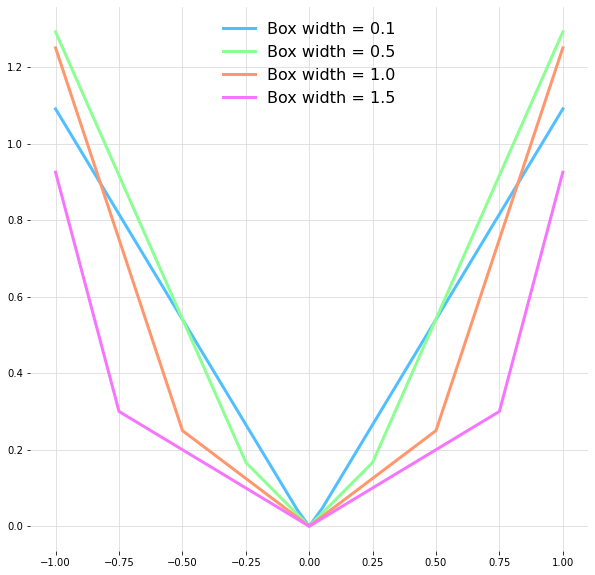

In [6]:
def boxe_dist(entity, box):
    width = box.right - box.left
    widthp1 = width + 1
    dist_inside = torch.abs(entity - box.center) / widthp1
    outside_mask = (entity < box.left) | (entity > box.right)
    kappa = 0.5 * width * (widthp1 - (1 / widthp1))
    dist_outside = torch.abs(entity - box.center) * widthp1 - kappa
    # dist = dist_inside.masked_fill(outside_mask, dist_outside)
    # return dist
    return torch.where(outside_mask, dist_outside, dist_inside)

plt.figure(figsize=(10, 10))
for i, box_width in enumerate(box_widths):
    box = make_box(box_width)
    plt.plot(x, boxe_dist(x, box).squeeze(0), color=colors[i], label=f"Box width = {box_width}", linewidth=3)
plt.legend(frameon=False, fontsize=16)
plt.show()

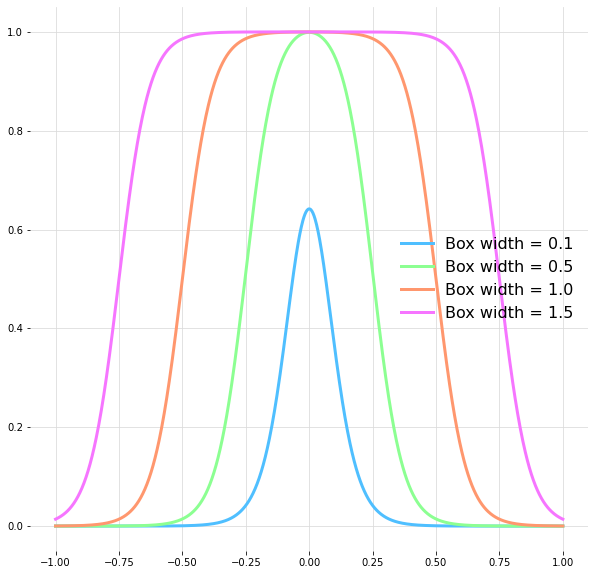

In [19]:
def normal_box_prob(entity, box, sigma=None):
    gamma = 1.702
    if sigma is None:
        sigma = (box.right - box.left) / 6
    temperature = gamma / sigma
    # result = torch.sigmoid(temperature * (entity - box.left)) + torch.sigmoid(temperature * (box.right - entity)) - 1
    result = torch.sigmoid(temperature * (entity - box.left)) - torch.sigmoid(temperature * (entity - box.right))
    result += result * (1 - torch.sigmoid(temperature * (box.center - box.left)) + torch.sigmoid(temperature * (box.center - box.right)))
    return result 

plt.figure(figsize=(10, 10))
for i, box_width in enumerate(box_widths):
    box = make_box(box_width)
    plt.plot(x, normal_box_prob(x, box, sigma=0.1).squeeze(0), color=colors[i], label=f"Box width = {box_width}", linewidth=3)
plt.legend(frameon=False, fontsize=16)
plt.show()

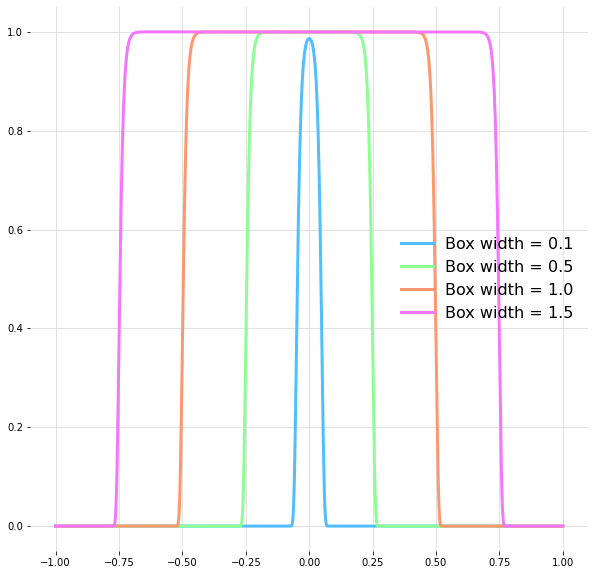

In [21]:
def gumbel_box_prob(entity, box, beta=0.1):
    return torch.exp(-torch.exp((box.left - entity) / beta)) + torch.exp(-torch.exp((entity - box.right) / beta)) - 1

plt.figure(figsize=(10, 10))
for i, box_width in enumerate(box_widths):
    box = make_box(box_width)
    plt.plot(x, gumbel_box_prob(x, box, beta=0.01).squeeze(0), color=colors[i], label=f"Box width = {box_width}", linewidth=3)
plt.legend(frameon=False, fontsize=16)
plt.show()